In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
C = torch.randn((27, 2))

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [10]:
# h = emb.view(32, 6) @ W1 + b1
# h = emb.view(-1, 6) @ W1 + b1
# h = emb.view(emb.shape[0], 6) @ W1 + b1

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h.shape

torch.Size([32, 100])

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2

In [15]:
logits.shape

torch.Size([32, 27])

In [16]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [17]:
prob.shape

torch.Size([32, 27])

In [18]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.0866)

In [19]:
# ----------------- now made respectable :) ------------------

In [20]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [22]:
sum(p.nelement() for p in parameters)

3481

In [23]:
for p in parameters:
    p.requires_grad = True

In [24]:
for _ in range(1000):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

17.76971435546875
13.656402587890625
11.298770904541016
9.452458381652832
7.984263896942139
6.891323089599609
6.100015640258789
5.452036380767822
4.8981523513793945
4.414664268493652
3.9858498573303223
3.6028308868408203
3.2621421813964844
2.96138072013855
2.6982970237731934
2.469712734222412
2.271660566329956
2.1012842655181885
1.957176923751831
1.8374860286712646
1.7380965948104858
1.6535117626190186
1.5790901184082031
1.5117673873901367
1.449605107307434
1.3913123607635498
1.3359928131103516
1.2830535173416138
1.232191801071167
1.1833821535110474
1.1367993354797363
1.092665195465088
1.0510929822921753
1.012027621269226
0.9752710461616516
0.9405569434165955
0.9076131582260132
0.8761925101280212
0.8460896015167236
0.8171363472938538
0.7891995310783386
0.7621749639511108
0.7359815835952759
0.710558295249939
0.6858615279197693
0.6618656516075134
0.6385658979415894
0.6159821152687073
0.5941662192344666
0.5732107162475586
0.553256630897522
0.5344885587692261
0.5171172618865967
0.501331806

In [25]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3347, 17.7906, 20.6013, 20.6118, 16.7355, 13.3347, 15.9986, 14.1725,
        15.9149, 18.3614, 15.9397, 20.9265, 13.3347, 17.1088, 17.1319, 20.0600,
        13.3347, 16.5889, 15.1016, 17.0579, 18.5863, 15.9671, 10.8740, 10.6872,
        15.5056, 13.3347, 16.1793, 16.9743, 12.7427, 16.2007, 19.0847, 16.0194],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [26]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [27]:
# ------------------- more respectable :) -------------------------

In [28]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

In [29]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [30]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [31]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
for p in parameters:
    p.requires_grad = True

In [33]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [34]:
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    print(loss.item())

21.80152130126953
18.669702529907227
20.235675811767578
19.364253997802734
21.145591735839844
19.27131462097168
18.257335662841797
17.69686508178711
17.496612548828125
20.699316024780273
18.59886932373047
16.97902488708496
19.624713897705078
18.69087028503418
18.258935928344727
17.97502326965332
18.31723976135254
17.227773666381836
15.160689353942871
17.387495040893555
15.892236709594727
20.539566040039062
16.711626052856445
19.239110946655273
21.653207778930664
19.90755844116211
19.440359115600586
20.000280380249023
17.939748764038086
20.108863830566406
19.3376407623291
16.2100830078125
18.382911682128906
15.472689628601074
18.83027458190918
18.021703720092773
19.797718048095703
16.796571731567383
18.599977493286133
19.371654510498047
18.42930793762207
16.5634822845459
20.368083953857422
19.224018096923828
17.35260772705078
18.06363868713379
20.073163986206055
16.890670776367188
22.31565284729004
16.99917221069336
16.650005340576172
19.398923873901367
17.716690063476562
18.40476608276

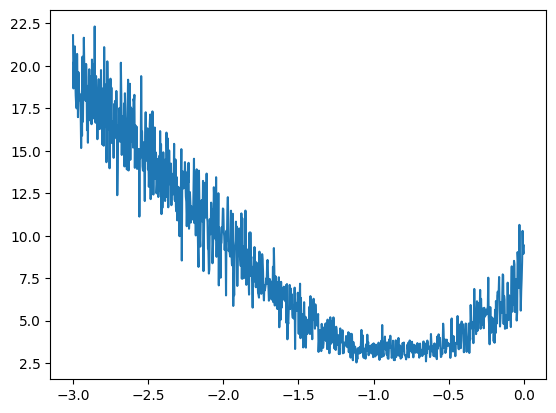

In [35]:
plt.plot(lri, lossi)

In [36]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(10.3803, grad_fn=<NllLossBackward0>)

In [37]:
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [38]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5084, grad_fn=<NllLossBackward0>)

In [39]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [41]:
for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [42]:
print(loss.item())

2.280888319015503


In [43]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4751, grad_fn=<NllLossBackward0>)

In [44]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4800, grad_fn=<NllLossBackward0>)

In [88]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [50]:
sum(p.nelement() for p in parameters)

10281

In [119]:
lri = []
lossi = []
stepi = []
for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

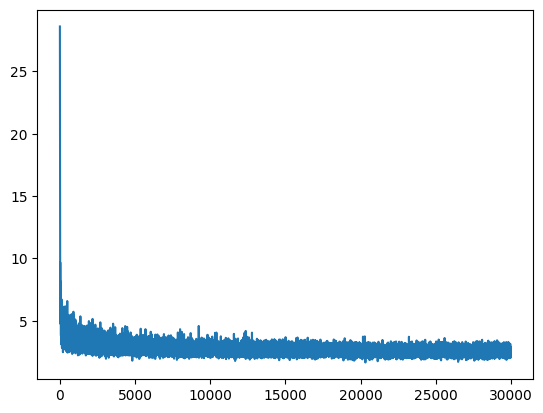

In [90]:
plt.plot(stepi, lossi)

In [120]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2035, grad_fn=<NllLossBackward0>)

In [121]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1814, grad_fn=<NllLossBackward0>)

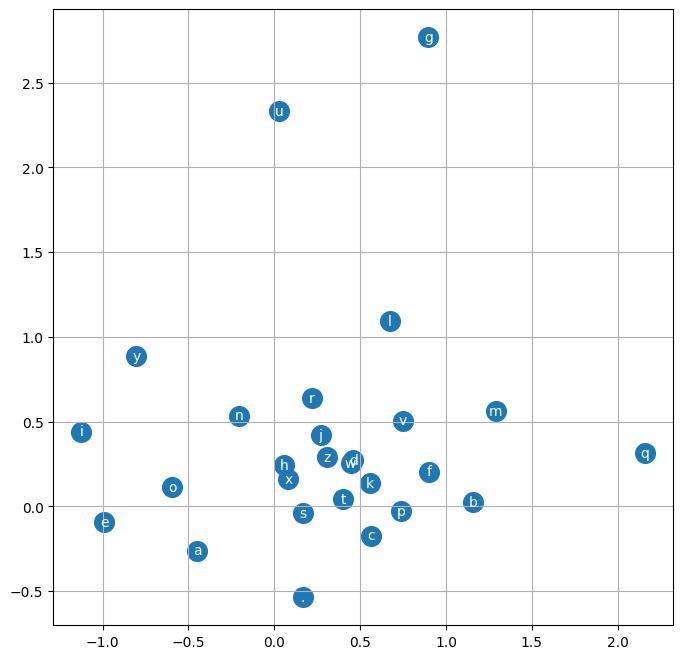

In [122]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [130]:
# increse dimensions of embedding
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [131]:
sum(p.nelement() for p in parameters)

11897

In [132]:
lri = []
lossi = []
stepi = []

In [146]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

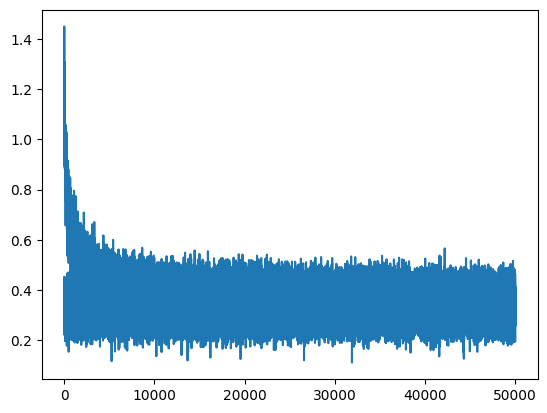

In [147]:
plt.plot(stepi, lossi)

In [148]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1906, grad_fn=<NllLossBackward0>)

In [149]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1647, grad_fn=<NllLossBackward0>)

In [150]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khirmyli.
tatyah.
cassa.
jazhith.
amerynt.
kaeli.
nermara.
chaiivia.
leigh.
ham.
pris.
quint.
sulin.
alia.
biai.
jero.
dearynix.
kaelyssua.
